***FOREX FINACIAL BOT***

This project is for learning purpose only.
Alpha Vantage will be the main source of the real time data. By use of requests library I was able to import the API from Alpha.

In [1]:
import requests

api_key = 'CIVEY6DJ1KKAUPZK'
symbol = 'AAPL'

url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&apikey={api_key}'
response = requests.get(url)
data = response.json()

print(data)

{'Meta Data': {'1. Information': 'Daily Prices (open, high, low, close) and Volumes', '2. Symbol': 'AAPL', '3. Last Refreshed': '2024-05-10', '4. Output Size': 'Compact', '5. Time Zone': 'US/Eastern'}, 'Time Series (Daily)': {'2024-05-10': {'1. open': '184.9000', '2. high': '185.0900', '3. low': '182.1300', '4. close': '183.0500', '5. volume': '50759496'}, '2024-05-09': {'1. open': '182.5600', '2. high': '184.6600', '3. low': '182.1100', '4. close': '184.5700', '5. volume': '48982972'}, '2024-05-08': {'1. open': '182.8500', '2. high': '183.0700', '3. low': '181.4500', '4. close': '182.7400', '5. volume': '45057087'}, '2024-05-07': {'1. open': '183.4500', '2. high': '184.9000', '3. low': '181.3200', '4. close': '182.4000', '5. volume': '77305771'}, '2024-05-06': {'1. open': '182.3540', '2. high': '184.2000', '3. low': '180.4200', '4. close': '181.7100', '5. volume': '78569667'}, '2024-05-03': {'1. open': '186.6450', '2. high': '187.0000', '3. low': '182.6600', '4. close': '183.3800', '5

**Data Preprocessing**

First, we shall start by converting the JSON data into a pandas dataframe.

In [2]:
import pandas as pd

df = pd.DataFrame(data['Time Series (Daily)']).T
df = df.rename(columns={'1. open': 'Open', '2. high': 'High', '3. low': 'Low', '4. close': 'Close', '5. volume': 'Volume'})
df = df.astype(float)
df.index = pd.to_datetime(df.index)
df = df.sort_index(ascending=True)

print(df.head())
print(df.tail())

              Open    High     Low   Close      Volume
2023-12-18  196.09  196.63  194.39  195.89  55751861.0
2023-12-19  196.16  196.95  195.89  196.94  40233138.0
2023-12-20  196.90  197.68  194.83  194.83  52242815.0
2023-12-21  196.10  197.08  193.50  194.68  46482549.0
2023-12-22  195.18  195.41  192.97  193.60  37149570.0
               Open    High     Low   Close      Volume
2024-05-06  182.354  184.20  180.42  181.71  78569667.0
2024-05-07  183.450  184.90  181.32  182.40  77305771.0
2024-05-08  182.850  183.07  181.45  182.74  45057087.0
2024-05-09  182.560  184.66  182.11  184.57  48982972.0
2024-05-10  184.900  185.09  182.13  183.05  50759496.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100 entries, 2023-12-18 to 2024-05-10
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    100 non-null    float64
 1   High    100 non-null    float64
 2   Low     100 non-null    float64
 3   Close   100 non-null    float64
 4   Volume  100 non-null    float64
dtypes: float64(5)
memory usage: 4.7 KB


In [4]:
df.describe()

,Open,High,Low,Close,Volume
count,100.000000,100.000000,100.00000,100.000000,1.000000e+02
mean,180.206140,181.598688,178.70290,180.113800,6.013941e+07
std,9.154721,8.929716,8.97813,9.047948,2.130633e+07
min,165.350000,166.400000,164.07500,165.000000,2.891931e+07
25%,171.185000,173.151250,169.90500,171.060000,4.671532e+07
50%,181.965000,183.000000,180.23500,181.810000,5.397694e+07
75%,186.698750,187.607500,184.56000,186.357500,6.866653e+07
max,196.900000,197.680000,195.89000,196.940000,1.632241e+08


**Visualizing the Data**

We shall use the matplotlib library to visualize the data. We shall plot the closing, opening, high and low price of the stock. All shall be plotted within a chart with multiple subplots.

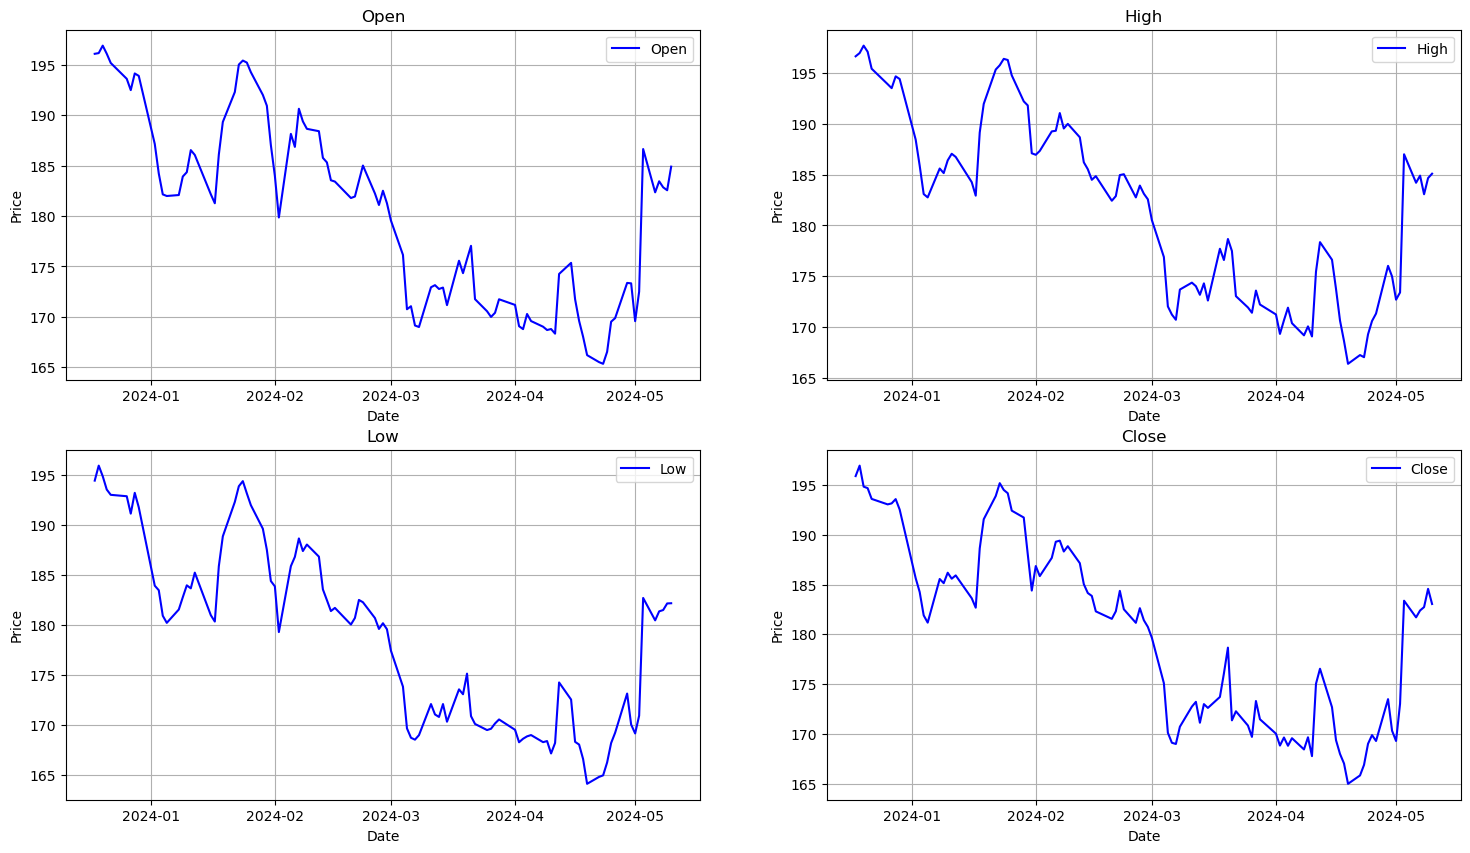

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 10))
for c in df.columns:
    if c != 'Volume':
        plt.subplot(2, 2, list(df.columns).index(c) + 1)
        plt.plot(df.index, df[c], label=c, color = 'blue')
        plt.title(c)
        plt.legend()
        plt.grid()
        plt.xlabel('Date')
        plt.ylabel('Price')

plt.show()


**Feature Engineering**

We shall create a new column that will be the difference between the closing price and the opening price. This will be used to determine if the stock price increased or decreased.

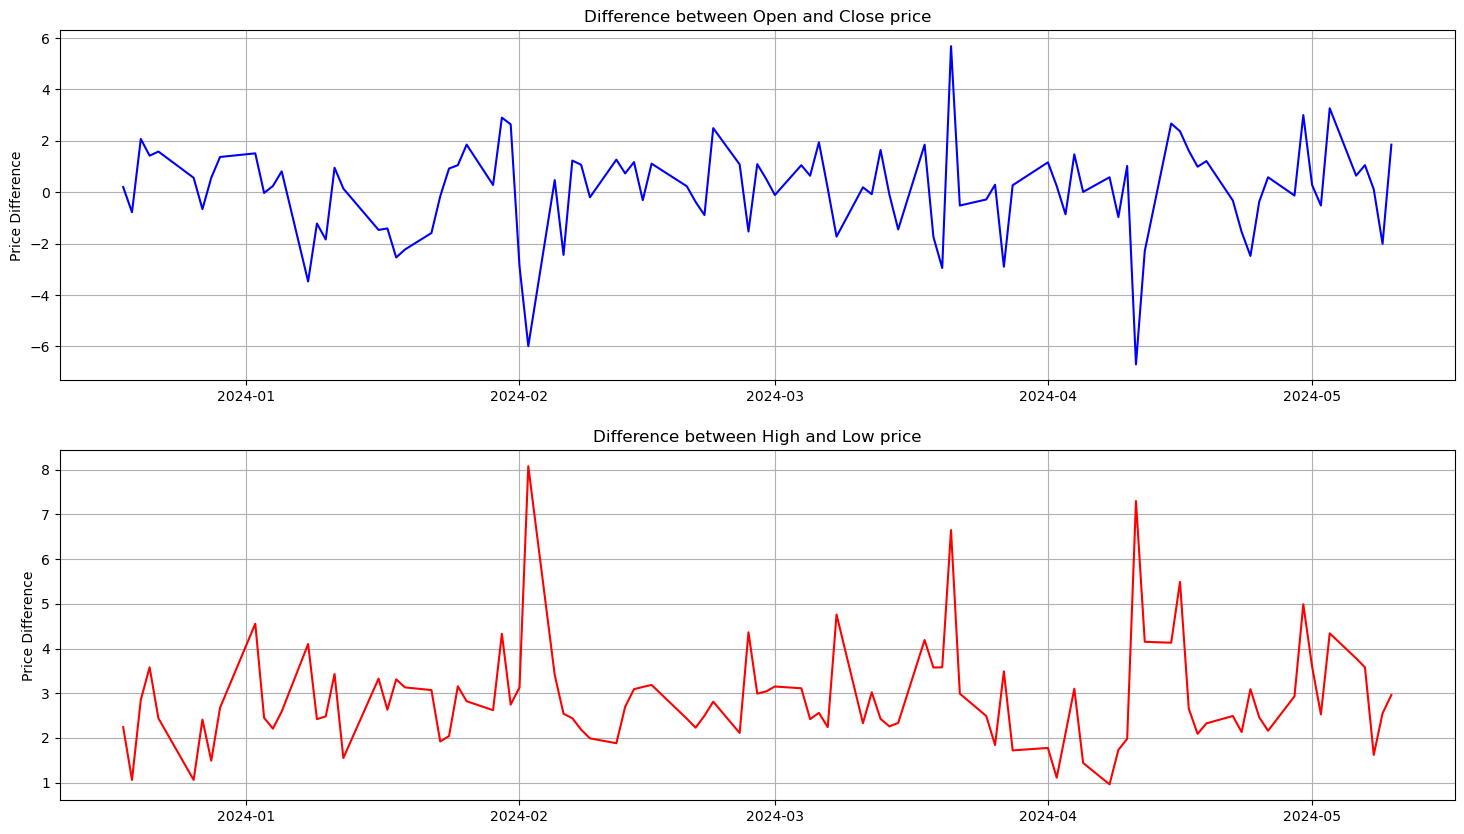

In [6]:
# finding difference between open and close price
df['Open-Close'] = df.Open - df.Close
df['High-Low'] = df.High - df.Low

plt.figure(figsize=(18, 10))
plt.subplot(2, 1, 1)    
plt.title('Difference between Open and Close price')
plt.plot(df.index, df['Open-Close'], color='blue')
plt.grid()
plt.ylabel('Price Difference')

plt.subplot(2, 1, 2)
plt.title('Difference between High and Low price')
plt.plot(df.index, df['High-Low'], color='red')
plt.grid()
plt.ylabel('Price Difference')

plt.show()

The difference above shows that the subtractions makes a stationary time series. This is important for the model to learn the patterns in the data.

**Moving Average Process**

We shall use Moving Average to smooth the data. This will help in removing the noise in the data. We shall use the 7 day moving average.

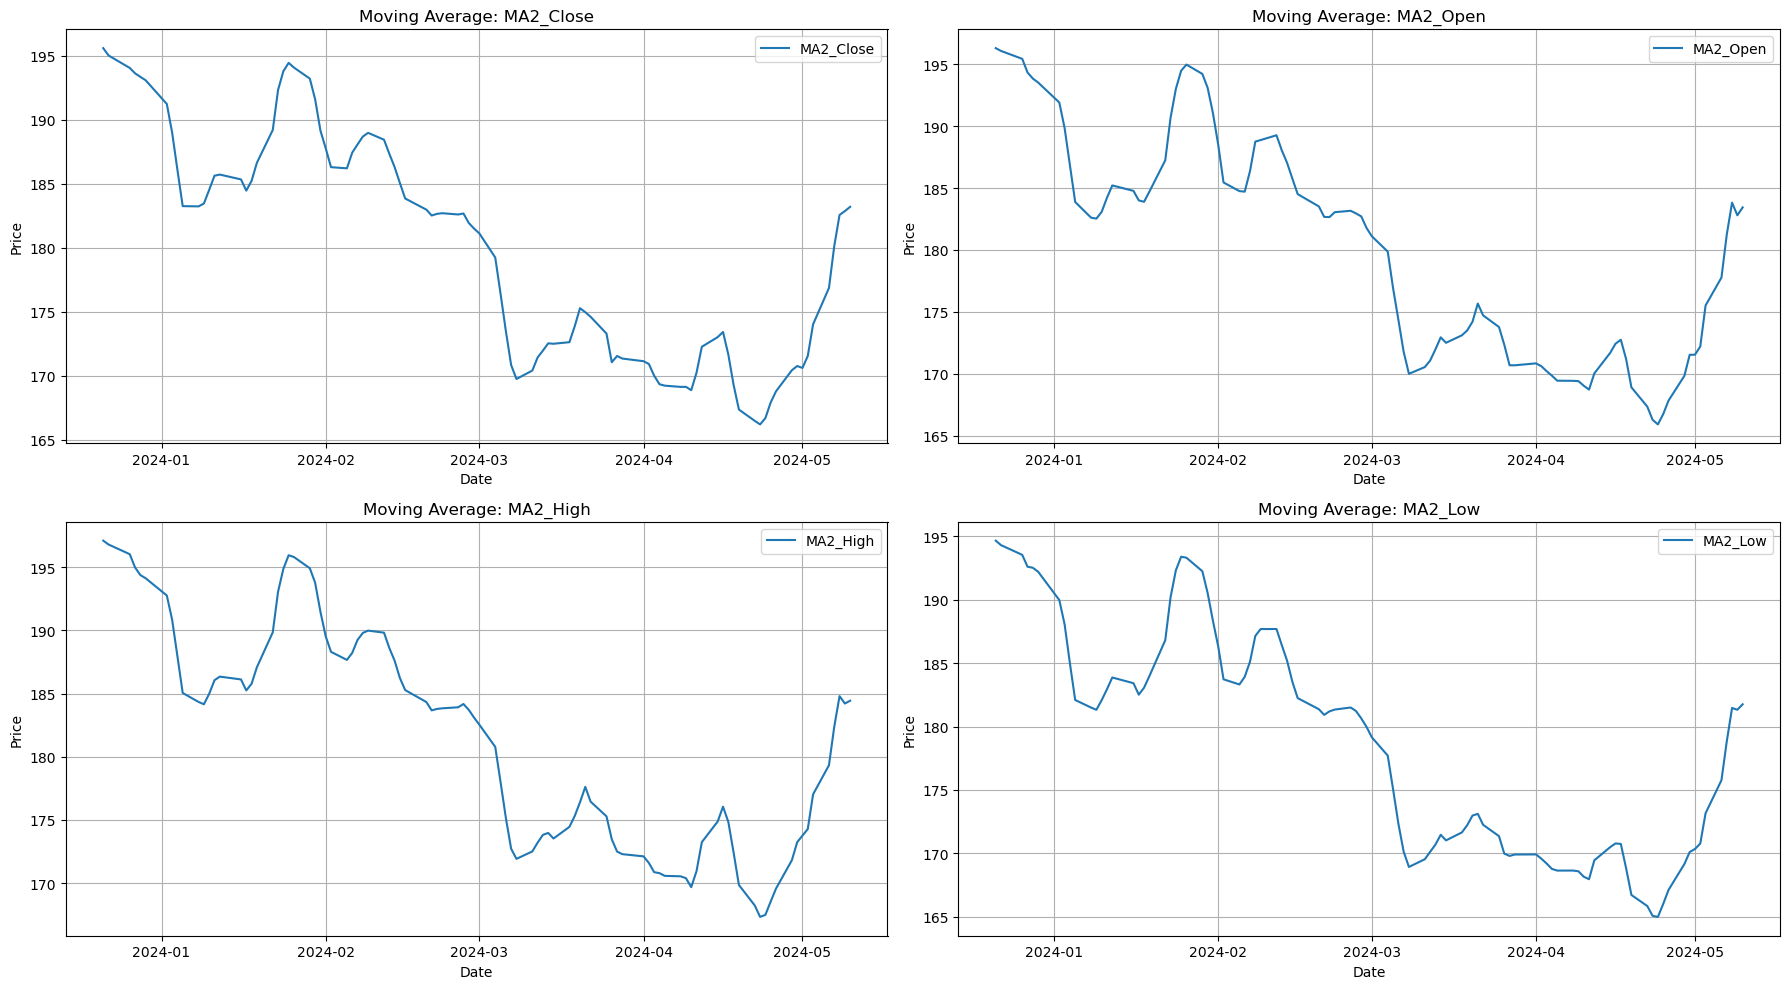

In [7]:
# Calculate moving averages
df['MA2_Close'] = df['Close'].rolling(window=4).mean()
df['MA2_Open'] = df['Open'].rolling(window=4).mean()
df['MA2_High'] = df['High'].rolling(window=4).mean()
df['MA2_Low'] = df['Low'].rolling(window=4).mean()

plt.figure(figsize=(18, 10))

# Loop through the moving averages and plot each one
for c in ['MA2_Close', 'MA2_Open', 'MA2_High', 'MA2_Low']:
    plt.subplot(2, 2, ['MA2_Close', 'MA2_Open', 'MA2_High', 'MA2_Low'].index(c) + 1)
    plt.plot(df.index, df[c], label=c)
    plt.title('Moving Average: ' + c)
    plt.legend()
    plt.grid()
    plt.xlabel('Date')
    plt.ylabel('Price')

plt.tight_layout()  # Adjust subplot layout to prevent overlapping
plt.show()

Lets move to the next step of creating X and y then we train and test them.

In [8]:
X = df[['MA2_Open', 'MA2_High', 'MA2_Low']].dropna()
y = df['MA2_Close'].dropna()


print(f"Length of X: {len(X)}")
print(f"Length of y: {len(y)}")
print(X.tail())
print(y.tail())

Length of X: 97
Length of y: 97
             MA2_Open   MA2_High   MA2_Low
2024-05-06  177.77225  179.33000  175.7700
2024-05-07  181.23975  182.37875  178.8225
2024-05-08  183.82475  184.79250  181.4625
2024-05-09  182.80350  184.20750  181.3250
2024-05-10  183.44000  184.43000  181.7525
2024-05-06    176.8550
2024-05-07    180.1300
2024-05-08    182.5575
2024-05-09    182.8550
2024-05-10    183.1900
Name: MA2_Close, dtype: float64


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(77, 3)
(20, 3)
(77,)
(20,)


Now we can do the linear regression on the model. Also, we can do Mean Squared Error to check the accuracy of the model. 

In [10]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error: ", mse)
print("R^2 Score: ", r2)

Mean Squared Error:  0.28103254436357017
R^2 Score:  0.9965460390356528


Let us check on correlations using a heatmap.

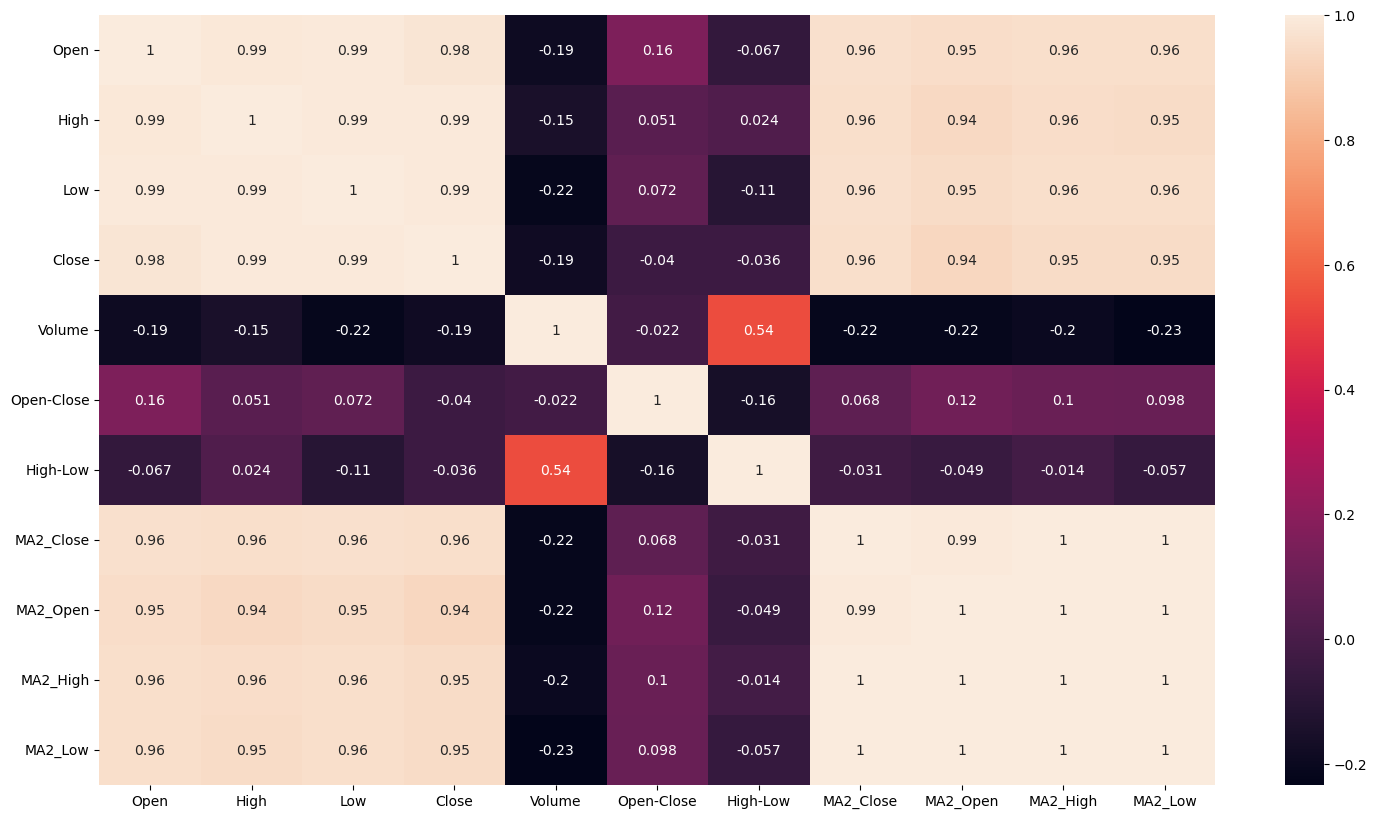

In [11]:
# plot correlation between actual and predicted values using heatmap
import seaborn as sns

plt.figure(figsize=(18, 10))
sns.heatmap(df.corr(), annot=True)
plt.show()

In [12]:
import joblib 

joblib.dump(model, "stock_model.pkl")

['stock_model.pkl']